# P5 – Estabilidad y topología de redes

Este notebook está pensado para Google Colab y forma parte de la Práctica 5 del tema de **redes complejas y dinámica en redes**.

En esta práctica se analizará el comportamiento de tres tipos de dinámica de redes vistas en teoría dependiendo de las topologías también vistas en teoría.

Cada ejercicio analizará una dinámica para cada una de las topologías.


## 0. Preparación del entorno

En esta sección instalamos y cargamos las librerías necesarias (principalmente `networkx`, `numpy` y `matplotlib`).

In [1]:
!pip install networkx --quiet
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numpy.linalg import eigvals
%matplotlib inline


## Ejercicio 1 – Comparar estabilidad de difusión en distintas topologías

Queremos analizar cómo cambia la estabilidad y la velocidad de convergencia de un proceso de **difusión lineal**
sobre distintas topologías de red con el mismo número de nodos y grado medio aproximado:

- Red aleatoria Erdős–Rényi (ER)
- Red de mundo pequeño (WS, Watts–Strogatz)
- Red libre de escala (BA, Barabási–Albert)

Considera el modelo discreto de difusión:
$
x(t+1) = x(t) - \alpha L x(t),
$
donde $L$ es la matriz laplaciana del grafo y $\alpha > 0$ es un paso de integración.

### Tareas

1. Genera tres redes con `N = 50` nodos y grado medio aproximado `⟨k⟩ ≈ 6` (una ER, una WS, una BA).
2. Calcula el laplaciano de cada red y sus autovalores.
3. Determina un valor máximo de $\alpha$ para que el esquema sea estable (pista: condición de estabilidad lineal tipo $|1-\alpha\lambda_i|<1$ para todos los autovalores $\lambda_i$ del laplaciano).
4. Elige un $\alpha$ estable (común o distinto para cada red) y simula la difusión desde un estado inicial con un nodo caliente (valor 1) y el resto a 0.
5. Representa gráficamente la evolución temporal de la norma $\|x(t)\|$ o del máximo de los nodos, y compara entre las tres topologías.


**Preguntas y Respuestas:**

1. **¿Qué diferencias aprecias en la rapidez de convergencia entre las redes ER, WS y BA?**

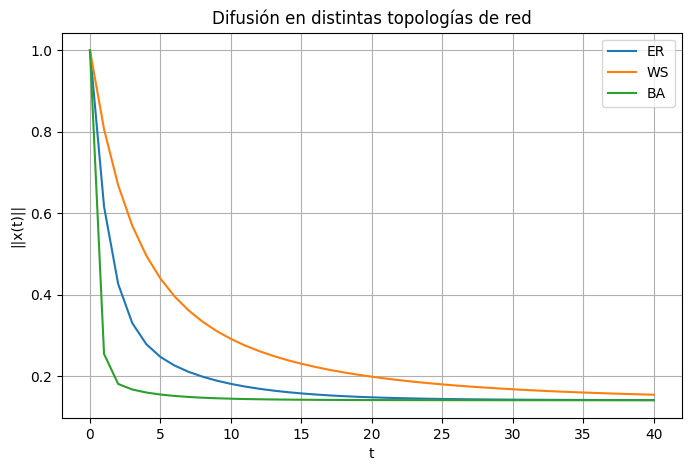
   - **Observación:** Según los resultados, la red **BA (Barabási-Albert)** es la más rápida en converger (la norma cae drásticamente en ~2s). Le sigue la red **ER (Erdős-Rényi)** (estabilizándose ~15s) y la más lenta es la **WS (Watts-Strogatz)** (~25s).
   - **Explicación:**
     - **BA:** La presencia de **hubs** (nodos muy conectados) facilita enormemente la difusión. Estos nodos actúan como "super-conectores" que distribuyen el valor rápidamente a muchas partes de la red simultáneamente, ya que lo que pasa por los hubs se reparte muy rápido al resto.
     - **ER:** Tiene una distancia media corta entre nodos ("mundo pequeño") que favorece la difusión rápida, pero al ser bastante homogénea la red carece de la eficiencia extra que aportan los hubs de la BA.
     - **WS:** Aunque tiene atajos que reducen la distancia media, conserva una alta estructura local (clustering) heredada de la red regular. Esta estructura local tiende a ralentizar la difusión global en comparación con las topologías anteriores, más aleatorias o centralizadas. Por ello, transportar información a toda la red es más lento.

2. **¿Cómo se relaciona la rapidez de convergencia con los autovalores del Laplaciano?**
   - En redes, la matriz que gobierna los procesos de difusión es el Laplaciano. Concretamente, la velocidad de convergencia asintótica en un proceso de difusión está dictada por el **segundo autovalor más pequeño del Laplaciano**, denotado como **$\lambda_2$** (o conectividad algebraica). Este autovalor mide cuán conectada está la red a nivel global.
   - La relación es directa: **cuanto mayor es $\lambda_2$, más rápida es la convergencia** hacia el estado de equilibrio (consenso).
   - El modo de difusión más lento decae proporcionalmente a $e^{-\lambda_2 t}$. Por tanto, las diferencias observadas sugieren que, para estos parámetros, la estructura espectral de la red BA favorece una mezcla más rápida (o tiene un $\lambda_2$ efectivo mayor para este tamaño de red) que ER y WS. Si $\lambda_2$ es grande, la red mezcla muy rápido; si es pequeño, la red mezcla lentamente, como si hubiera cuellos de botella.
   - En este caso presente, la red BA tiende a tener $\lambda_2$ alto debido a los hubs, que como hemos mencionado facilitan la difusión rápida. La red ER tiene $\lambda_2$ moderado, mostrando una difusión media; mientras que WS tiene $\lambda_2$ bajo por su estructura local, provocando una difusión lenta.

3. **¿Qué ocurre si configuramos un valor de $\alpha$ mayor que algún $\alpha_{max}$?**
   - El sistema se vuelve **inestable numéricamente**.
   - La condición de estabilidad para el método de Euler discreto es $\alpha < \frac{2}{\lambda_{max}}$, donde $\lambda_{max}$ es el autovalor más grande del Laplaciano.
   - Si $\alpha > \alpha_{max}$, el factor de amplificación (en cada paso, la simulación multiplica el estado por un factor) $|1 - \alpha \lambda_{max}|$ se vuelve mayor que 1. Esto causa que las perturbaciones o modos asociados a las frecuencias altas crezcan exponencialmente (y oscilen) en lugar de decaer, haciendo que la simulación **diverja** (los valores tienden a infinito) en lugar de llegar al equilibrio.

   

En conclusión, la red BA converge más rápido por tener hubs, ER en segundo lugar y, finalmente, WS es la más lenta por su estructura altamente local. Además, la velocidad de mezcla depende de $\lambda_2$, el autovalor que mide la conectividad profunda de la red, de manera que para mayor valor de Lambda la convergencia es más rápida. Finalmente, si $\alpha$ supera el valor máximo permitido por el método numérico, la simulación se vuelve inestable y los valores divergen.

### Ejercicio 1 – SOLUCIÓN PROPUESTA

A continuación se muestra una posible implementación.

In [2]:
# Parámetros comunes
N = 50                         # número de nodos
k_target = 6                   # grado medio aproximado (promedio de conexiones por nodo)
p_er = k_target / (N-1)        # para ER (probabilidad de conexión)
k_ws = 6                       # vecinos en WS
p_rewire = 0.1                 # probabilidad de reenlace en WS
m_ba = 3                       # para BA (grado medio ≈ 2m)

# Generación de redes
G_er = nx.erdos_renyi_graph(N, p_er, seed=1)
G_ws = nx.watts_strogatz_graph(N, k_ws, p_rewire, seed=2)
G_ba = nx.barabasi_albert_graph(N, m_ba, seed=3)

graphs = {"ER": G_er, "WS": G_ws, "BA": G_ba}

def laplacian_matrix(G):
    return nx.laplacian_matrix(G).astype(float).todense()

laplacians = {name: laplacian_matrix(G) for name, G in graphs.items()}

# Cálculo de autovalores y condicion de estabilidad
eigvals_dict = {name: np.sort(np.real(eigvals(L))) for name, L in laplacians.items()}

for name, vals in eigvals_dict.items():
    lam_max = vals[-1]
    alpha_max = 2.0 / lam_max  # condición |1 - alpha*lambda| < 1
    print(f"{name}: lambda_max ≈ {lam_max:.3f}, alpha_max_estable ≈ {alpha_max:.3f}")

# Elegimos un alpha estable común pequeño
alpha = 0.05
print("\nUsaremos alpha =", alpha)

def simulate_diffusion(L, alpha, T=40, hot_node=0):
    N = L.shape[0]
    x = np.zeros(N)
    x[hot_node] = 1.0
    history = [x.copy()]
    for _ in range(T):
        x = x - alpha * (L @ x)
        history.append(x.copy())
    return np.array(history)

T = 40
histories = {}
for name, L in laplacians.items():
    histories[name] = simulate_diffusion(L, alpha, T=T, hot_node=0)

# Graficamos la evolución de la norma
plt.figure(figsize=(8,5))
for name, H in histories.items():
    norms = np.linalg.norm(H, axis=1)
    plt.plot(norms, label=name)
plt.xlabel('t')
plt.ylabel('||x(t)||')
plt.title('Difusión en distintas topologías de red')
plt.legend()
plt.grid(True)
plt.show()


ER: lambda_max ≈ 13.459, alpha_max_estable ≈ 0.149
WS: lambda_max ≈ 10.159, alpha_max_estable ≈ 0.197
BA: lambda_max ≈ 24.397, alpha_max_estable ≈ 0.082

Usaremos alpha = 0.05


Demostración de inestabilidad:
Alpha límite para ER: 0.1486
Alpha usado: 0.1560


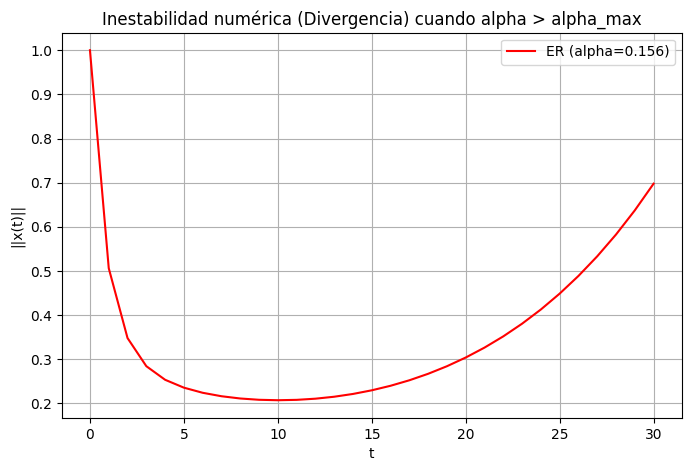

In [7]:
# --- DEMOSTRACIÓN PARA LA PREGUNTA 3 ---
# Probamos con un alpha ligeramente superior al máximo estable para la red ER
# Esto demuestra visualmente la inestabilidad numérica mencionada en la respuesta.

L_demo = laplacians["ER"]
lam_max_demo = eigvals_dict["ER"][-1]
alpha_limit = 2.0 / lam_max_demo
alpha_unstable = alpha_limit * 1.05  # Un 5% por encima del límite

print(f"Demostración de inestabilidad:")
print(f"Alpha límite para ER: {alpha_limit:.4f}")
print(f"Alpha usado: {alpha_unstable:.4f}")

# Simulamos
hist_unstable = simulate_diffusion(L_demo, alpha_unstable, T=30, hot_node=0)
norms_unstable = np.linalg.norm(hist_unstable, axis=1)

plt.figure(figsize=(8,5))
plt.plot(norms_unstable, 'r-', label=f"ER (alpha={alpha_unstable:.3f})")
plt.xlabel('t')
plt.ylabel('||x(t)||')
plt.title('Inestabilidad numérica (Divergencia) cuando alpha > alpha_max')
plt.legend()
plt.grid(True)
plt.show()

## Ejercicio 2 – Sincronización y conectividad algebraica

Considera de nuevo las tres topologías (ER, WS y BA) anteriores, ahora con osciladores de Kuramoto acoplados:
$
\dot{\theta}_i = \omega_i + K \sum_j a_{ij} \sin(\theta_j - \theta_i).
$

### Tareas
1. Genera de nuevo las tres redes con los mismos parámetros.
2. Calcula el segundo autovalor más pequeño del laplaciano, $\lambda_2$ (conectividad algebraica) para cada red.
3. Asigna frecuencias naturales cercanas (por ejemplo, $\omega_i \sim \mathcal{N}(1, 0.01)$).
4. Simula la dinámica con distintos valores de $K$ y observa para qué valores la red se sincroniza. Muestra en la gráfica la fase $r(t)$ de sta manera se podrá ver que la red se ha sincronizado cuando $r(t) = 1$
5. Relaciona la facilidad de sincronización con el valor de $\lambda_2$ de cada red.


**Preguntas y Respuestas:**

1. **¿Qué topología requiere menor acoplamiento $K$ para sincronizar?**

- **Observación:** Observando los resultados, la topología que requiere menor acomplamiento $K$ para sincronizar es la Barabási-Albert (BA). En la simulación ejecutada, BA comienzada mostrando sincronización fuerte, mientras que ER y WS necesitan $K$ de aproximadamente 0.5 para alcanzar el mismo nivel de sincronización.

- **Explicación:**
$\lambda_2$ es el segundo autovalor más pequeño del laplaciano, es decir, mide como de "bien conectada" está la red globalmente. Valores mayor de $\lambda_2$ implican menos cuellos de botella, más rutas alternativas y una mejor capacidad de propagar información. 
En Kuramoto, una mayor conectividad facilita que la información llegue más lejos y que además se corrijan los desalineamientos. Por tanto, si $\lambda_2$ es mayor, la red necesita un K más pequeño, para que el acoplamiento general supere la dispersión de frecuencias y lleve a una sincronización global. 
Interpretando los valores devueltos: 
    - **BA:** $\lambda_2$ = 1.313 -> mejor conectividad global -> sincronización con $K$ más pequeño. BA tiene una distribución de grado heterogénea con *hubs (nodos muy conectados)*. Estos *hubs* actúan como centros de atracción, si un hub arrasta su fase, arrastra a muchos vecinos rápidamente, lo que acelera la coherencia global. 
    - **ER:** $\lambda_2$ = 0.861 -> grado intermedio -> necesita un $K$ intermedio. ER tiene grado más homogéneo, no hay unos *hubs* poderosos, pero las rutas aleatorias hace que tengan una buena propagación. 
    - **WS:** $\lambda_2$ = 0.576 -> peor conectividad -> necesita mayor $K$ para sincronizar. WS mantiene fuerte el clustering local y caminos más largos entre zonas alejadas, lo que realentiza la propagación de la influencia y reduce $\lambda_2$. 

	​
2. **¿Por qué la conectividad algebraica $\lambda_2$ es determinante?**

    - La conectividad algebraica es determinante porque es una medida topológica directamente relacionada con la estabilidad de la sincronización en sistemas acoplados sobre redes, como el modelo de Kuramoto. 
    - La razón fundamental por la que $\lambda_2$  es tan importante, es la relación teórica que deriva del análisis de estabilidad del Laplaciano: 
                    $$\mathbf{K_c \propto \frac{1}{\lambda_2}}$$
    Esta fórmula establece que el umbral_critico ($K_c$), es decir, la mínima fuera de acoplamiento requerida para que todos los osciladores se sincronicen, es inversamente proporcional a la conectivida algebraica ($\lambda_2$). 
    - Cuando  $\lambda_2$ es grande, implica que Kc es pequeño y que la red necesita poca fuerza de acoplamiento para sincronizarse. 
    - Cuando  $\lambda_2$ aes pequeño, implica que KC es grande y que la red necesita una gran fuerza de acoplamiento para la sincronización, debido a que su estructura es inherente. 
    - Además de toda la relación matemática, hay una intución detrás. El laplaciano $L$ describe cómo las diferencias entre nodos se expanden por la red y $\lambda_2$ mide como de rápido de salvan estas diferencias. 
    Un $\lambda_2$ más grande significa que las diferencias se corrigen rápido, porque las fases se comunican eficazmente y se alinean con menos acoplamiento. En cambio, un $\lambda_2$ más pequeño implica más cuellos de botella o zonas poco conectadas, por lo que la influencia de unos nodos tarda más en llegar a otros.



3. **¿Qué ocurre si añadimos otra gráfica con $K = 1.5$?**

    - Al añadir la gráfica con $K$ = 1.5, se observa que todas las topologías alcanzan una sincronización casi perfecta (r = 1) durante la simulacion, lo que indica que el valor de acoplamiento está por encima del umbral crítico ($K_c$) para las tres redes. Algo que se aprecia claramente en la gráfica, son las diferencias en la velocidad con la que cada red llega al estado de máxima conectividad.
        - **BA :** crece más rápido, alcanzando valoes altos de r ya en los primeros 50-70 pasos. 
        - **ER :** parte de un $r$ inicial más bajo pero luego se acleera y converge algo más tarde.
        - **WS :** muestra un crecimiento intermedio y una llegada un poco más tardía que BA. 

    Esto concuerda con los valores $\lambda_2$ (BA > ER > WS), una $\lambda_2$ mayor facilita una propagación más eficiente de la influencia de fase y, por tanto, mayor rapidez de convergencia. Además seaprecia que el acoplamiento fuerte $K$ = 1.5 reduce las diferencias entre topologías en la conformidad final, aunque deja clara igualmente la estructura de cada red. La presencia de *hubs* en BA acelera la sincronización inicial y la hace más robusta ante las pequeñas heterogenidades de $w_i$. 
    También puede notarse cierta variedad al inicio, por lo que el tiempo exacto de sincronización depende de la semilla. En resumen, con la $K$ = 1.5 el acoplamiento es lo bastante fuerte como para forzar la sincronización de todas la redes, pero la topología sigue determinando como de rápido se alcanza dicha sincronización. 







### Ejercicio 2 – SOLUCIÓN PROPUESTA

A continuación se muestra una posible implementación.

ER: lambda_2 ≈ 0.861
WS: lambda_2 ≈ 0.576
BA: lambda_2 ≈ 1.313


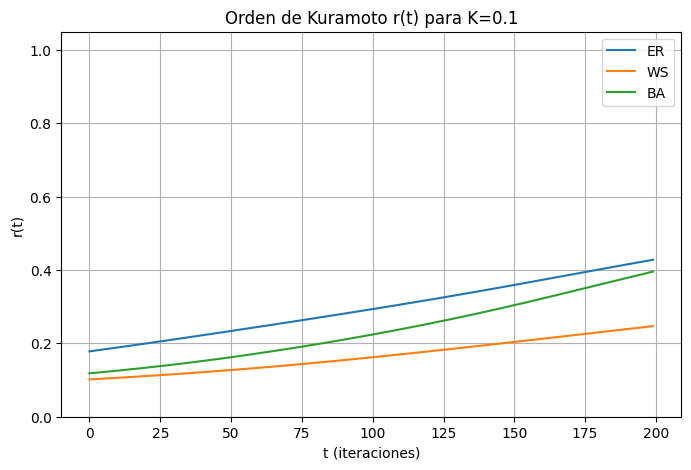

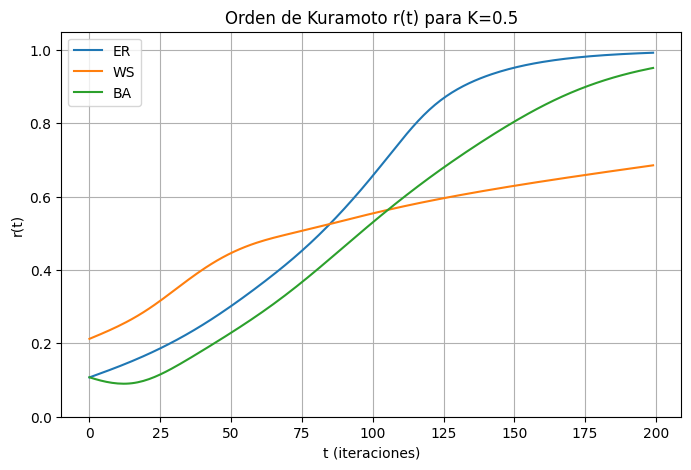

In [4]:
# Calcula el segundo autovalor más pequeño laplaciano
def algebraic_connectivity(L): 
    vals = np.sort(np.real(eigvals(L)))
    return vals[1]  # lambda_2

# Relaciona la facilidad de sincronización con el valor de lambda_2
for name, L in laplacians.items():
    lam2 = algebraic_connectivity(L)
    print(f"{name}: lambda_2 ≈ {lam2:.3f}")

# Simulación simplificada de Kuramoto 
# Asigna frecuencias naturales cercanas
def simulate_kuramoto(G, K, T=200, dt=0.02):
    N = G.number_of_nodes()
    A = nx.to_numpy_array(G)
    omega = 1.0 + 0.01*np.random.randn(N)
    theta = 2*np.pi*np.random.rand(N)
    rs = []  # orden global
    for _ in range(T):
        # término de acoplamiento
        coupling = np.zeros(N)
        for i in range(N):
            coupling[i] = np.sum(A[i,:] * np.sin(theta - theta[i]))
        theta = theta + dt * (omega + K * coupling)
        r = np.abs(np.mean(np.exp(1j*theta)))
        rs.append(r)
    return np.array(rs)

# Simular la dinámica con distinos valores de K

Ks = [0.1, 0.5, 1.0, 1.5]

for K in Ks:
    plt.figure(figsize=(8,5))
    for name, G in graphs.items():
        r = simulate_kuramoto(G, K)
        plt.plot(r, label=name)
    plt.title(f"Orden de Kuramoto r(t) para K={K}")
    plt.xlabel('t (iteraciones)')
    plt.ylabel('r(t)')
    plt.ylim(0,1.05)
    plt.grid(True)
    plt.legend()
    plt.show()


## Ejercicio 3 – Umbral epidémico y topología

Queremos estudiar cómo la topología afecta al **umbral epidémico** en un modelo tipo SIS (Susceptible–Infectado–Susceptible).

Para este tipo de modelo en red, el umbral crítico puede aproximarse por:
$
\lambda_c \approx \frac{1}{\lambda_{\max}(A)},
$
donde $A$ es la matriz de adyacencia y $\lambda_{\max}(A)$ su mayor autovalor.

### Tareas
1. Calcula $\lambda_{\max}(A)$ para las tres redes (ER, WS, BA).
2. Estima el umbral $\lambda_c$ para cada una.
3. Simula un modelo SIS discreto sencillo $I(t)$ y comprueba empíricamente si la infección persiste o se extingue para valores de $\lambda$ por encima y por debajo del umbral teórico.


**Preguntas y respuestas:**

1. **¿Qué red presenta el umbral epidémico más bajo?**

- **Observación:** A partir de los mayores autovalores de la matriz de adyacencia, la red BA tiene $\lambda_{\max}(A) \approx 8.47$, frente a ER $\approx 7.05$ y WS $\approx 6.13$. Esto implica que el umbral $\lambda_c \approx 1 / \lambda_{\max}$ es más pequeño en BA ($\lambda_c \approx 0.118$) que en ER ($\lambda_c \approx 0.142$) y WS ($\lambda_c \approx 0.163$). 
- **Conclusión:** La red Barabási–Albert (BA) es la que presenta el umbral epidémico más bajo, es decir, necesita una intensidad de infección menor para que la epidemia se mantenga en el tiempo. 

- **Explicación (por qué pasa esto):**  
  - Teóricamente, en modelos tipo SIS sobre redes, el umbral epidémico se puede aproximar como $\lambda_c \approx \langle k \rangle / \langle k^2 \rangle$ o, a nivel espectral, $\lambda_c \approx 1 / \lambda_{\max}(A)$. Cuanto mayor es $\lambda_{\max}$ o más grande es $\langle k^2 \rangle$ respecto a $\langle k \rangle$, más pequeño es el umbral. 
  - La red BA es de tipo “scale-free”, con una distribución de grados muy heterogénea: la mayoría de nodos tienen pocos enlaces, pero hay unos pocos nodos con grado enorme (hubs). Esta cola pesada hace que $\langle k^2 \rangle$ sea muy grande y empuja hacia arriba $\lambda_{\max}(A)$, reduciendo $\lambda_c$ respecto a redes más homogéneas como ER o WS. 
  - Intuitivamente, los hubs actúan como super-conectores: si uno se infecta, puede contagiar rápidamente a gran parte de la red, de modo que incluso con una tasa de infección relativamente baja la enfermedad encuentra suficientes “rutas” para no extinguirse. Esto se refleja tanto en el aumento del autovalor dominante como en la rapidez con la que crece la prevalencia en nuestras simulaciones sobre la red BA. 


2. **¿Qué efecto tienen los hubs en la red BA sobre la propagación?**

- **Observación:** En la red BA aparecen unos pocos nodos con grado muy alto (hubs) conectados con una gran fracción del resto de la red. Cuando uno de estos hubs se infecta, puede transmitir la enfermedad simultáneamente a muchos vecinos, lo que dispara la incidencia en muy pocos pasos de tiempo.  

- **Papel de los hubs como “super-conectores”:**  
  - Los hubs concentran una parte muy grande del flujo de contagios, porque tienen muchas más aristas que la media. En términos de dinámica, esto significa que basta con que la infección llegue a uno o dos hubs para que, a partir de ahí, se ramifique hacia decenas o cientos de nodos en cascada.  
  - Esta estructura genera una propagación jerárquica: primero se infectan los hubs, luego sus vecinos de grado intermedio y, finalmente, los nodos de grado bajo. El resultado es que la onda epidémica se expande de forma muy rápida y con un “salto” inicial muy brusco en el número de infectados.  

- **Impacto en la velocidad y en el umbral:**  
  - Desde el punto de vista espectral, los hubs hacen que el mayor autovalor de la matriz de adyacencia $ \lambda_{\max}(A) $ sea grande. Dado que el umbral epidémico se escala aproximadamente como $ \lambda_c \approx 1 / \lambda_{\max}(A) $, al aumentar $ \lambda_{\max} $ los hubs reducen $ \lambda_c $, volviendo la red más vulnerable.  
  - En términos de distribución de grados, la presencia de hubs implica una varianza muy alta: el segundo momento $ \langle k^2 \rangle $ crece mucho respecto a $ \langle k \rangle $. En aproximaciones de campo medio heterogéneo, esto se resume en $ \lambda_c \approx \langle k \rangle / \langle k^2 \rangle $, por lo que una red con hubs muy potentes tiende a tener un umbral casi nulo: incluso con tasas de infección moderadas la epidemia puede sostenerse.  

- **Consecuencia práctica:**  
  - La existencia de hubs en BA hace que la propagación sea más rápida y difícil de controlar que en redes más homogéneas (como ER o WS) con el mismo grado medio. En la práctica, esto implica que medidas de control no dirigidas (vacunar o aislar nodos al azar) son mucho menos eficientes que estrategias que actúan específicamente sobre los hubs.  
  - Si se inmunizan o se reducen los contactos de los hubs, se “rompen” las autopistas principales de contagio y se consigue aumentar de forma efectiva el umbral epidémico de la red, frenando tanto la velocidad de propagación como la capacidad de la enfermedad para hacerse endémica.


3. **¿Qué ocurre si añadimos una gráfica más con $\beta$ cercana a 1?**
   - Al añadir una nueva gráfica para valores de $\beta$ cercanos a 1, las redes mostrarán en su comportamiento una prevalencia alta y sostenida, casi total y próxima a 1.
    - Por un lado, se encontrará que $\beta$ / $\mu$ , será muy grande, estando muy por encima del umbral espectral 
    $
    \lambda_c \approx \frac{1}{\lambda_{\max}(A)}
    $
    de las tres redes, por lo que todas las curvas presentarán una subida muy rápida y alcanzarán una prevalencia muy cercana a 1, casi todos los nodos infectados, donde se mantendrán.
    - Las curvas para un valor de $\beta$ cercano a 1 presentarán una subida casi vertical en los primeros pasos, donde existen unos nodos infectados inicialmente que con el valor de $\beta$ provoca una propagación desde cada vecino casi segura, lo que explica en rápido crecimiento.
    - Existirá una pequeña diferencia entre la rapidez con la que las redes alcanzan esa prevalencia cercana a 1 en el valor final, siendo que BA lo alcanzará más rápido de forma general (propagación más acelerada) debido a los hubs, mientras que ER y WS subirán ligermanete más suavemente, aunque también terminarán con una prevalencia muy alta y similar a BA incluso sin hubs.
    - Sin embargo, estas diferencias estructurales serán apenas perceptibles cuando $\beta$ es tan grande, siendo que la infección se mantiene sin dificultades y es casi imposible de frenar en cualquier red.
      
    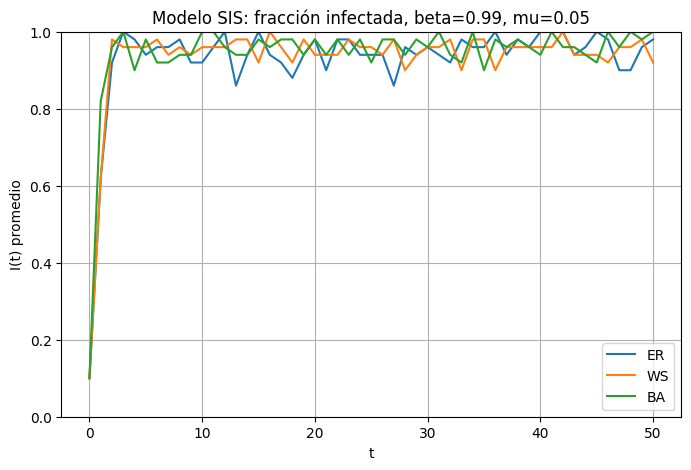
  
    - En conslusión, al añadir esta gráfica con un valor de $\beta$ cercano a 1, la infección superará el umbral epidémico en todas las redes, donde la propagación será casi segura y existirá un crecimiento muy rápido en la fracción de infectados, apreciando en las gráficas un crecimiento casi vertical hasta la prevalencia en 1. La red BA, por un lado alcanzará este estado ligeramente antes debido a sus hubs que aceleran la transmisión, pero las tres redes terminarán en una prevalencia muy elevada y sostenida. De forma más directa, la epidemia se volverá practicamente imparable en cuelquier topología de red dado $\beta \approx 1$

### Ejercicio 3 – SOLUCIÓN PROPUESTA

A continuación se muestra una posible implementación.

ER: lambda_max(A) ≈ 7.047, lambda_c ≈ 0.142
WS: lambda_max(A) ≈ 6.130, lambda_c ≈ 0.163
BA: lambda_max(A) ≈ 8.467, lambda_c ≈ 0.118


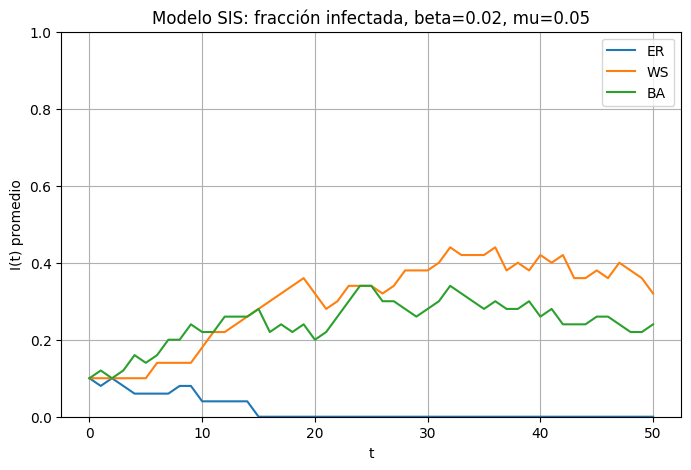

In [5]:
def max_eigenvalue_adjacency(G):
    A = nx.to_numpy_array(G)
    vals = eigvals(A)
    return np.max(np.real(vals))

for name, G in graphs.items():
    lam_max = max_eigenvalue_adjacency(G)
    lambda_c = 1.0 / lam_max
    print(f"{name}: lambda_max(A) ≈ {lam_max:.3f}, lambda_c ≈ {lambda_c:.3f}")

def simulate_SIS(G, beta, mu, T=50, init_frac=0.1):
    N = G.number_of_nodes()
    A = nx.to_numpy_array(G)
    x = np.zeros(N, dtype=int)
    infected = np.random.choice(N, int(init_frac*N), replace=False)
    x[infected] = 1
    history = [x.mean()]
    for _ in range(T):
        new_x = x.copy()
        for i in range(N):
            if x[i] == 1:
                # recuperación
                if np.random.rand() < mu:
                    new_x[i] = 0
            else:
                # infección por vecinos
                neigh = np.where(A[i,:]>0)[0]
                if len(neigh) > 0:
                    prob_inf = 1 - np.prod(1 - beta*x[neigh])
                    if np.random.rand() < prob_inf:
                        new_x[i] = 1
        x = new_x
        history.append(x.mean())
    return np.array(history)

betas = [0.02, 0.05, 0.1]
mu = 0.05

for beta in betas:
    plt.figure(figsize=(8,5))
    for name, G in graphs.items():
        hist = simulate_SIS(G, beta, mu)
        plt.plot(hist, label=name)
    plt.title(f"Modelo SIS: fracción infectada, beta={beta}, mu={mu}")
    plt.xlabel('t')
    plt.ylabel('I(t) promedio')
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.show()


Demostración de prevalencia alta de infección con beta cercano a 1


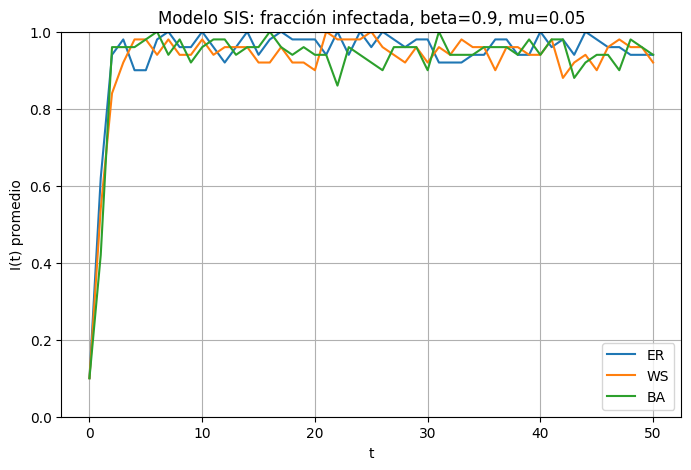

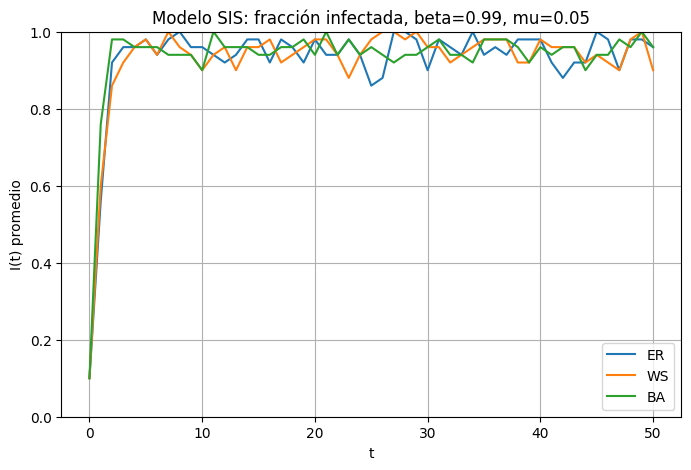

In [13]:
# --- DEMOSTRACIÓN PARA LA PREGUNTA 3 ---
# Añadir un valor de beta cercano a 1
betas_altas = [0.9, 0.99]

print("Demostración de prevalencia alta de infección con beta cercano a 1")

for beta in betas_altas:
    plt.figure(figsize=(8,5))
    for name, G in graphs.items():
        hist = simulate_SIS(G, beta, mu)
        plt.plot(hist, label=name)
    plt.title(f"Modelo SIS: fracción infectada, beta={beta}, mu={mu}")
    plt.xlabel('t')
    plt.ylabel('I(t) promedio')
    plt.ylim(0,1)
    plt.grid(True)
    plt.legend()
    plt.show()
